# Compile the main simulator code using cython 

In [1]:
!python ../setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_plasticity.cpython-38-darwin.so -> 
running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_stop_signal.cpython-38-darwin.so -> 
/Users/cristina/Desktop/CBGTpy_5HT_new/CBGTPy/notebooks/agent_timestep_stop_signal.cpython-38-darwin.so
/Users/cristina/Desktop/CBGTpy_5HT_new/CBGTPy/notebooks/agent_timestep_plasticity.cpython-38-darwin.so


# Import all the relevant files 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import pathos.multiprocessing

In [3]:
import sys
sys.path.append('../')

#Importing scripts:

#Import relevant frames:
import common.cbgt as cbgt
import common.pipeline_creation as pl_creat

#Import plotting functions:
import common.plotting_functions as plt_func
import common.plotting_helper_functions as plt_help
import common.postprocessing_helpers as post_help

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

Choose the experiment to run, and define the number of choices, the number of simulations/thread to run and number of cores:

In [4]:
#Choose the experiment:
experiment_choice = 'stop-signal'

if experiment_choice == 'stop-signal':
    import stopsignal.paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import nchoice.paramfile_nchoice as paramfile

number_of_choices = 1

#Choose which multiprocessing library to use:
use_library = "none" # "none" or "pathos" or "ray"


# how many simulations do you want to run? each simulation is executed as a separate thread.
num_sims = 1
num_cores = 7


#Call choose_pipeline with the pipeline object:
pl_creat.choose_pipeline(experiment_choice)
#Create the main pipeline:
pl = pl_creat.create_main_pipeline(runloop=True)

#Set a seed:
seed = np.random.randint(0,99999999,1)[0]
print(seed)

in choose pipeline
in reward pipeline
75434668


Define data and figures directories:

In [5]:
data_dir = "../Data/"
figure_dir = "../Figures/"

# Running the pipeline

### Define configuration parameter

In [272]:
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None,
    'thalamic_threshold': 50.,
    'movement_time': ["constant", 300], #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout': 100000, 
    
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'srtns': paramfile.srtndefaults, 
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'd1_srtn': paramfile.d1defaults_srtn,
    'channels' : pd.DataFrame([["left"]], columns=['action']), #action channels related parameters
    'number_of_choices': number_of_choices,
    'newpathways' : None,     #connectivity parameters
    'Q_support_params': None, #initialization of Q-values update
    'Q_df_set': pd.DataFrame([[0.5]],columns=["left"]), #initialized Q-values df  
    'n_trials': 1,            #number of trials
    'volatility': [None,"exact"], #frequency of changepoints
    'conflict': (1.0),         #probability of the preferred choice
    'reward_mu': 1,               #mean for the magnitude of the reward
    'reward_std': 0.1,            #std for the magnitude of the reward
    'maxstim': 0,               #amplitude of the cortical input over base line
    'sustainedfraction': 0.75,
    
    'thalamostriatal_plasticity_present': True, # whether plasticity is on or "off" at thalamostriatal synapses
    
    #Stop signal
    'stop_signal_present': [False, False],
    'stop_signal_probability': [1., 1.],  #probability of trials that will get the stop-signal / list of trial numbers
    'stop_signal_amplitude': [0.6, 0.6],  #amplitude of the stop signal over base line
    'stop_signal_onset': [60.,60.],       #in ms
    'stop_signal_duration' : ["phase 0",165.], 
    'stop_signal_channel': ["all","left"], #"all" (all channels are given the stop signal) 
                                            #"any" (channel given the stop signal is chosen randomly)
                                            # [list of channels] == subset of channels given the stop signal
    'stop_signal_population':["STN","GPeA"],
    
    'record_variables':["weight", "weight_srtn_dSPN"],
    
    
    #Opto signal
    'opt_signal_present': [False],
    'opt_signal_probability': [1.], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude': [.7],   #amplitude of the stop signal over base line
    'opt_signal_onset': [30.],      #in ms
    'opt_signal_duration': ["phase 0"],
    'opt_signal_channel': ["all"],  # "all" (all channels are given the stop signal) 
                                    #"any" (channel given the stop signal is chosen randomly)
                                    # [list of channels] == subset of channels given the stop signal
    
    'opt_signal_population':["dSPN"],
}

### Run the simulation

ExecutionManager class can take for 'use': 

- 'none', that corresponds to the singlethreaded mode;
- 'pathos', that corresponds to python's multiprocessing mode;
- 'ray', that corresponds to a multiprocessing library for python that operates on a client-server mode.

The default value is None (singlethreaded mode).

In [273]:
results = cbgt.ExecutionManager(cores=num_cores,use=use_library).run([pl]*num_sims,[configuration]*num_sims)

in choose pipeline
SpawnThreadManagers <common.backend.Pipeline object at 0x7f7a398ea2b0>
scaling_conn 1
scaling_wts 2.0
SpawnThreadManagers <common.backend.Pipeline object at 0x7f7a398eaa60>
SpawnThreadManagers <common.backend.Pipeline object at 0x7f7a398c89a0>
scaling_conn 1
scaling_wts 2.0
SpawnThreadManagers <common.backend.Pipeline object at 0x7f7a398f6b80>
gateFRs [11.11111111]
thresholds_crossed []
trial_num 0
chosen_action: none
scaled serotonin signal 1.0
in


# Results

List all the agent variables accessible: 

In [274]:
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'srtns', 'd1', 'd2', 'd1_srtn', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'thalamostriatal_plasticity_present', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_duration', 'stop_signal_channel', 'stop_signal_population', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'par', 'popconstruct', 'interface', 'gen_stop', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'rece

In [275]:
results[0]['popdata']

,name,action,N,C,Taum,RestPot,ResetPot,Threshold,RestPot_ca,Alpha_ca,...,srtn_type,srtn_alphaw,srtn_gamma,srtn_wmax,srtn_wmin,srtn_a,srtn_b,srtn_c,srtn_wbase,column
0,GPi`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,0
1,STN`,left`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,1
2,GPeP`,left`,560`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,2
3,GPeA`,left`,190`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,3
4,dSPN`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,1`,-2.64`,0.0001`,0.4`,0.01`,1.0`,0.001`,1.0`,0.3285`,4
5,iSPN`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,5
6,Cx`,left`,204`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,6
7,Th`,left`,75`,0.5`,27.78`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,7
8,FSI`,nan`,75`,0.2`,10`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,8
9,CxI`,nan`,186`,0.2`,10`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,9


In [277]:
agent = results[0]['agent']

In [280]:
experiment_choice

'stop-signal'

Extract all the relevant dataframes:

In [281]:
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [282]:
results[0]['pathways']

,src,dest,receptor,type,con,eff,plastic,biselector
0,Cx`,dSPN`,AMPA`,syn`,1.0`,0.022`,True`,<function MatchBiselector.<locals>.Biselector ...
1,Cx`,dSPN`,NMDA`,syn`,1.0`,0.03`,False`,<function MatchBiselector.<locals>.Biselector ...
2,Cx`,iSPN`,AMPA`,syn`,1.0`,0.022`,True`,<function MatchBiselector.<locals>.Biselector ...
3,Cx`,iSPN`,NMDA`,syn`,1.0`,0.028`,False`,<function MatchBiselector.<locals>.Biselector ...
4,Cx`,FSI`,AMPA`,all`,1.0`,0.17`,False`,<function MatchBiselector.<locals>.Biselector ...
5,Cx`,Th`,AMPA`,syn`,1.0`,0.025`,False`,<function MatchBiselector.<locals>.Biselector ...
6,Cx`,Th`,NMDA`,syn`,1.0`,0.029`,False`,<function MatchBiselector.<locals>.Biselector ...
7,dSPN`,dSPN`,GABA`,syn`,0.26`,0.28`,False`,<function MatchBiselector.<locals>.Biselector ...
8,dSPN`,iSPN`,GABA`,syn`,0.06`,0.42`,False`,<function MatchBiselector.<locals>.Biselector ...
9,dSPN`,GPi`,GABA`,syn`,1.0`,2.09`,False`,<function MatchBiselector.<locals>.Biselector ...


In [283]:
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed
0,0,GPi_left,71.333333,GPi,left,75434668_0
1,1,GPi_left,71.333333,GPi,left,75434668_0
2,2,GPi_left,71.333333,GPi,left,75434668_0
3,3,GPi_left,72.000000,GPi,left,75434668_0
4,4,GPi_left,71.555556,GPi,left,75434668_0
...,...,...,...,...,...,...
1009035,100899,CxI_common,2.419355,CxI,common,75434668_0
1009036,100900,CxI_common,2.419355,CxI,common,75434668_0
1009037,100901,CxI_common,2.419355,CxI,common,75434668_0
1009038,100902,CxI_common,2.419355,CxI,common,75434668_0


Extract the data tables from the agent:

In [284]:
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,none,0,100001,100001,100302,100302,left,0


In [286]:
len(agent.hist_srtn_w_d1)

100903

In [287]:
reshaped_srtn_w_d1 = np.reshape(agent.hist_srtn_w_d1, (len(agent.hist_srtn_w_d1), 1))
reshaped_srtn_w_d1

array([[0.31224888],
       [0.31223967],
       [0.31223042],
       ...,
       [0.32846293],
       [0.32846293],
       [0.32846293]])

In [288]:
srtn_w1_df = pd.DataFrame(reshaped_srtn_w_d1, columns=['weight_ThdSPN'])
timer = np.arange(len(srtn_w1_df.index))
srtn_w1_df.loc[:, "time"] = timer

In [289]:
srtn_w1_df

,weight_ThdSPN,time
0,0.312249,0
1,0.312240,1
2,0.312230,2
3,0.312220,3
4,0.312210,4
...,...,...
100898,0.328463,100898
100899,0.328463,100899
100900,0.328463,100900
100901,0.328463,100901


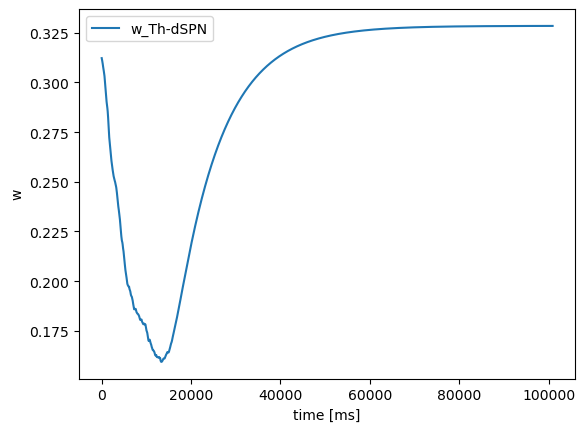

In [290]:
sns.lineplot(x='time', y='weight_ThdSPN', data= srtn_w1_df, label='w_Th-dSPN')
#sns.lineplot(x='time', y='right', data= srtn_w1_df, color='darkorange')
plt.ylabel('w')
plt.xlabel('time [ms]')
plt.legend()

In [291]:
srtn_w1_df_phase0 = pd.DataFrame(reshaped_srtn_w_d1, columns=['left'])
timer = np.arange(len(srtn_w1_df_phase0.index))
srtn_w1_df_phase0.loc[:, "time"] = timer
srtn_w1_df_phase0.time = srtn_w1_df_phase0.time%300000
srtn_w1_df_phase0.loc[:, "seed"] = seed

In [292]:
srtn_w1_df_phase0

,left,time,seed
0,0.312249,0,75434668
1,0.312240,1,75434668
2,0.312230,2,75434668
3,0.312220,3,75434668
4,0.312210,4,75434668
...,...,...,...
100898,0.328463,100898,75434668
100899,0.328463,100899,75434668
100900,0.328463,100900,75434668
100901,0.328463,100901,75434668


In [293]:
w_average_phase0 = pd.DataFrame(srtn_w1_df_phase0.groupby(['time']).mean()).reset_index()
w_average_phase0

,time,left,seed
0,0,0.312249,75434668.0
1,1,0.312240,75434668.0
2,2,0.312230,75434668.0
3,3,0.312220,75434668.0
4,4,0.312210,75434668.0
...,...,...,...
100898,100898,0.328463,75434668.0
100899,100899,0.328463,75434668.0
100900,100900,0.328463,75434668.0
100901,100901,0.328463,75434668.0


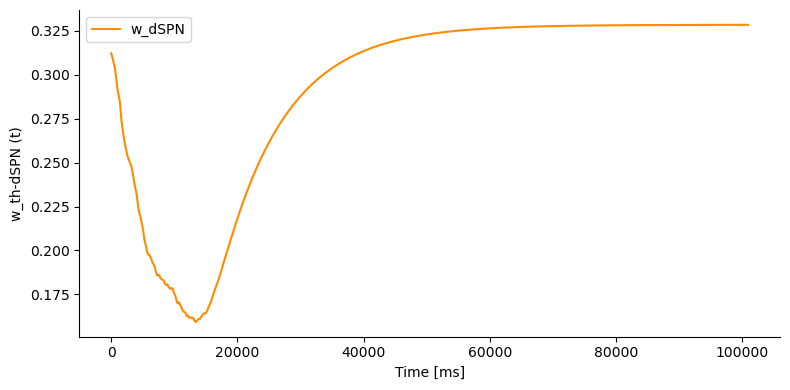

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1,1, figsize=(8, 4), tight_layout=True) #4

#sns.lineplot(data=w_average_phase0, x='time', y='right', errorbar=('ci', 95), ax=ax1) 
sns.lineplot(data=w_average_phase0, x='time', y='left', color='darkorange', errorbar=('ci', 95), ax=ax1, label='w_dSPN')
ax1.set_ylabel('w_th-dSPN (t)')
ax1.set_xlabel('Time [ms]')
#ax1.set_xlim(0, 300000)

ax1.spines[['right', 'top']].set_visible(False)
plt.savefig(figure_dir+'average_weights_d1_check', dpi=300)

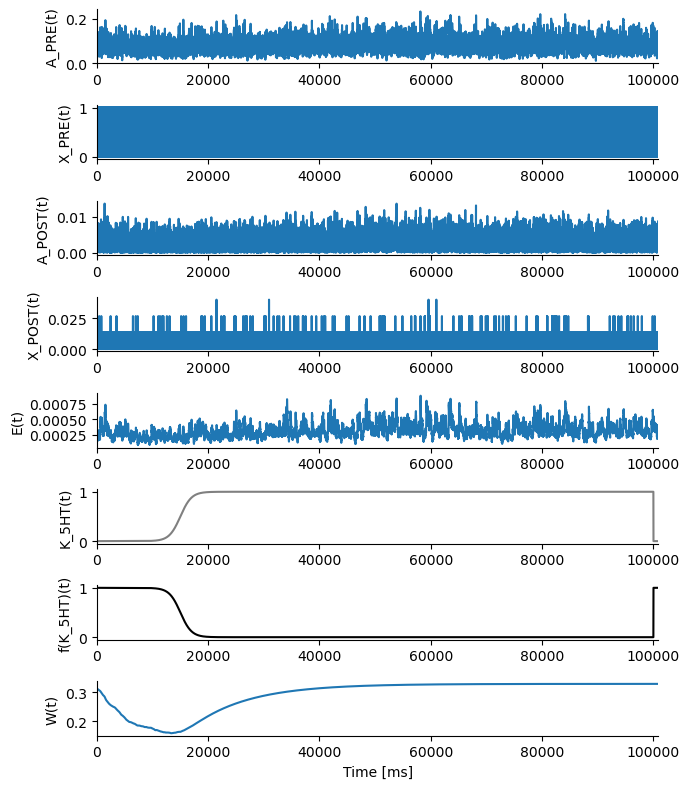

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8,1, figsize=(7, 8), tight_layout=True) #4

ax1.plot(agent.hist_srtn_APRE)
ax1.set_ylabel('A_PRE(t)')
#ax1.set_ylim(0, 0.001)
ax2.plot(agent.hist_srtn_XPRE)
#ax2.set_ylim(0, 0.001)
ax2.set_ylabel('X_PRE(t)')
ax3.plot(agent.hist_srtn_APOST)
ax3.set_ylabel('A_POST(t)')
ax4.plot(agent.hist_srtn_XPOST)
ax4.set_ylabel('X_POST(t)')
ax5.plot(agent.hist_srtn_E)
ax5.set_ylabel('E(t)')
ax6.plot(agent.hist_srtn_f5HT_D1, color='gray')
ax6.set_ylabel('K_5HT(t)')
ax7.plot(agent.hist_srtn_fK5HT_D1, color='black')
ax7.set_ylabel('f(K_5HT)(t)')
sns.lineplot(x='time', y='weight_ThdSPN', data= srtn_w1_df, ax=ax8)
#sns.lineplot(x='time', y='right', data= srtn_w1_df, color='darkorange', ax=ax7)
ax8.set_ylabel('W(t)')
ax8.set_xlabel('Time [ms]')

#sns.lineplot(y='weights', x='trials', data=weights_df, hue='nuclei', ax=ax8)
#ax8.set_ylabel('W(t).mean')
#ax8.set_xlabel('Trials')


ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax3.spines[['right', 'top']].set_visible(False)
ax4.spines[['right', 'top']].set_visible(False)
ax5.spines[['right', 'top']].set_visible(False)
ax6.spines[['right', 'top']].set_visible(False)
ax7.spines[['right', 'top']].set_visible(False)
ax8.spines[['right', 'top']].set_visible(False)

ax1.set_xlim(0, len(agent.hist_srtn_w_d2))
ax2.set_xlim(0, len(agent.hist_srtn_w_d2))
ax3.set_xlim(0, len(agent.hist_srtn_w_d2))
ax4.set_xlim(0, len(agent.hist_srtn_w_d2))
ax5.set_xlim(0, len(agent.hist_srtn_w_d2))
ax6.set_xlim(0, len(agent.hist_srtn_w_d2))
ax7.set_xlim(0, len(agent.hist_srtn_w_d2))
ax8.set_xlim(0, len(agent.hist_srtn_w_d2))

#ax7.set_ylim(0, 0.39)

plt.savefig(figure_dir+'srtn_on_weights_check', dpi=300)

In [312]:
results[0]['popdata']

,name,action,N,C,Taum,RestPot,ResetPot,Threshold,RestPot_ca,Alpha_ca,...,srtn_alphaw,srtn_gamma,srtn_wmax,srtn_wmin,srtn_a,srtn_b,srtn_c,srtn_wbase,column,newname
0,GPi`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,0,GPi_left`
1,STN`,left`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,1,STN_left`
2,GPeP`,left`,560`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,2,GPeP_left`
3,GPeA`,left`,190`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,3,GPeA_left`
4,dSPN`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,-2.64`,0.0001`,0.4`,0.01`,1.0`,0.001`,1.0`,0.3285`,4,dSPN_left`
5,iSPN`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,5,iSPN_left`
6,Cx`,left`,204`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,6,Cx_left`
7,Th`,left`,75`,0.5`,27.78`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,7,Th_left`
8,FSI`,nan`,75`,0.2`,10`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,8,nan`
9,CxI`,nan`,186`,0.2`,10`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,9,nan`


In [315]:
EPSP_d1_1 = []
EPSP_d1_2 = []

for i in agent.hist_EPSP_d1_1:
    EPSP_d1_1.append(i[0][0]*1)

for i in agent.hist_EPSP_d1_2:
    EPSP_d1_2.append(i[0][0]*1)

EPSC_d1 = []

for i in agent.hist_EPSC_d1:
    EPSC_d1.append(i[0][0]*1)

In [316]:
srtn_w1_df

,weight_ThdSPN,time
0,0.312249,0
1,0.312240,1
2,0.312230,2
3,0.312220,3
4,0.312210,4
...,...,...
100898,0.328463,100898
100899,0.328463,100899
100900,0.328463,100900
100901,0.328463,100901


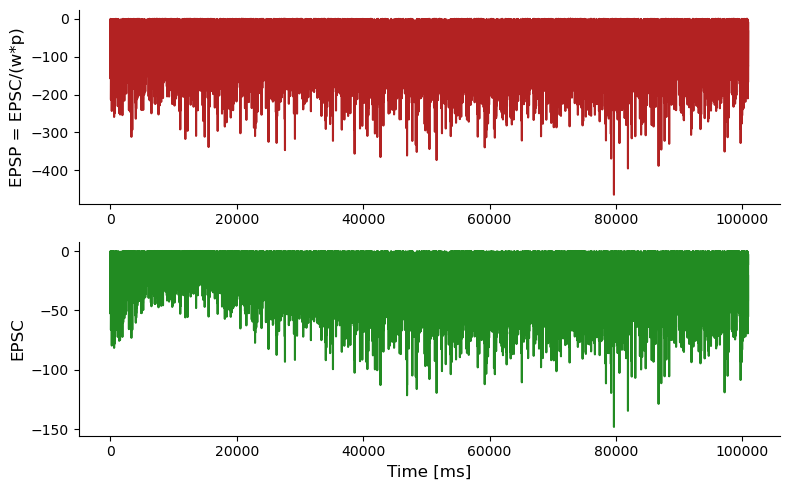

In [318]:
from scipy.fft import fft, ifft

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), tight_layout=True) #4

ax1.plot(EPSP_d1_1, color='firebrick')
ax2.plot(EPSC_d1, color='forestgreen')
#ax.plot(trial_right, label='right')
ax1.set_ylabel('EPSP = EPSC/(w*p)', fontsize=12.)
#ax1.set_xlabel('Time [ms]', fontsize=12.)
ax2.set_ylabel('EPSC', fontsize=12.)
ax2.set_xlabel('Time [ms]', fontsize=12.)
#ax.set_xlim(-1000, results[0]['choice_timeout'])
#plt.legend()
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)


plt.savefig(figure_dir+'EPS_d1_1.png')

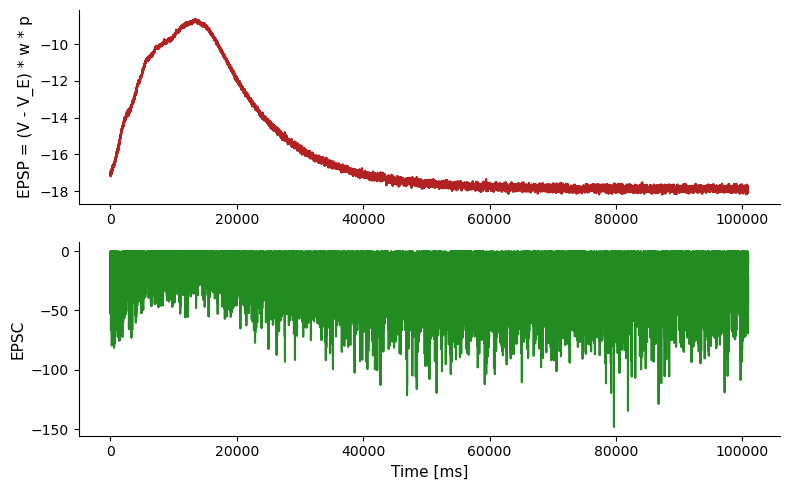

In [319]:
from scipy.fft import fft, ifft

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), tight_layout=True) #4

ax1.plot(EPSP_d1_2, color='firebrick')
ax2.plot(EPSC_d1, color='forestgreen')
#ax.plot(trial_right, label='right')
ax1.set_ylabel('EPSP = (V - V_E) * w * p', fontsize=11.)
#ax1.set_xlabel('Time [ms]', fontsize=12.)
ax2.set_ylabel('EPSC', fontsize=11.)
ax2.set_xlabel('Time [ms]', fontsize=11.)
#ax.set_xlim(-1000, results[0]['choice_timeout'])
#plt.legend()
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)


plt.savefig(figure_dir+'EPS_d1_2.png')

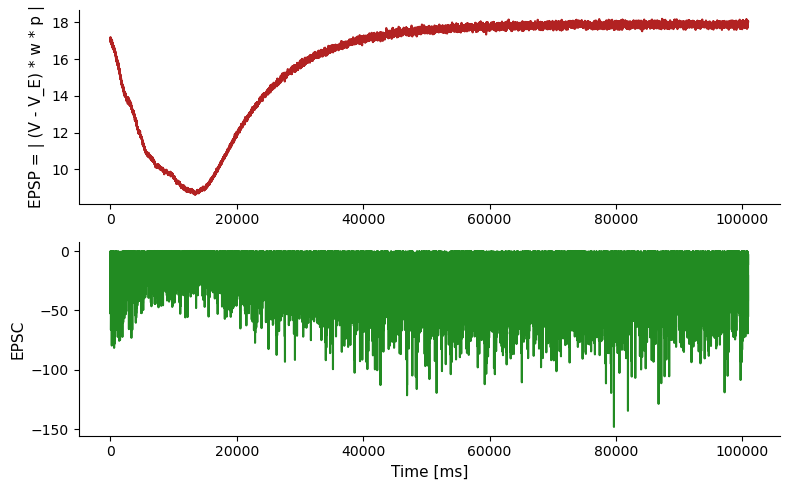

In [320]:
from scipy.fft import fft, ifft

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), tight_layout=True) #4

ax1.plot(np.abs(EPSP_d1_2), color='firebrick')
ax2.plot(EPSC_d1, color='forestgreen')
#ax.plot(trial_right, label='right')
ax1.set_ylabel('EPSP = | (V - V_E) * w * p |', fontsize=11.)
#ax1.set_xlabel('Time [ms]')
ax2.set_ylabel('EPSC', fontsize=11.)
ax2.set_xlabel('Time [ms]', fontsize=11.)
#ax.set_xlim(-1000, results[0]['choice_timeout'])
#plt.legend()
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)


plt.savefig(figure_dir+'EPS_d1_2_abs.png')

In [321]:
#EPSP_d1_2_perc = EPSP_d1_2/np.abs(np.min(EPSP_d1_2)) * 100
EPSP_d1_2_perc = np.abs(EPSP_d1_2)/np.max(np.abs(EPSP_d1_2)) * 100

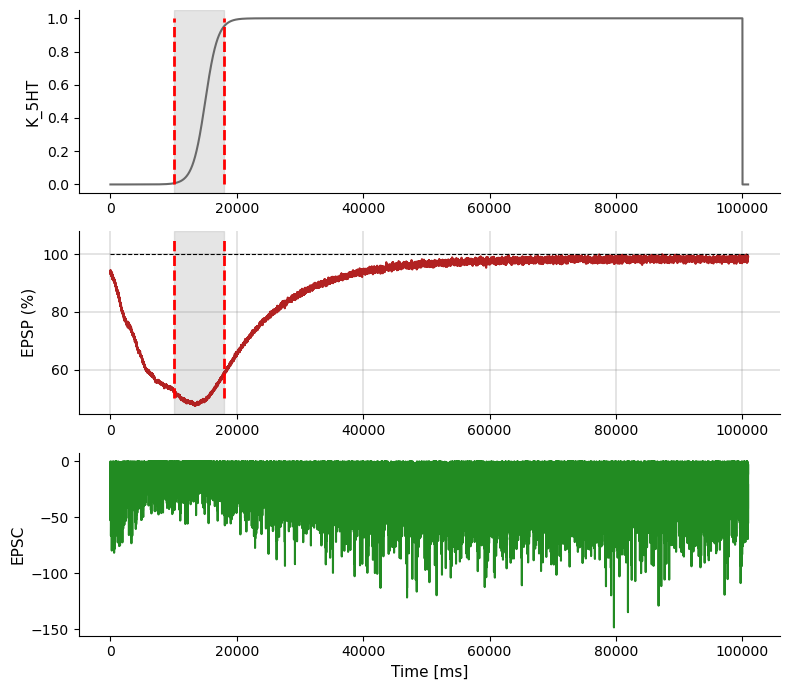

In [324]:
from scipy.fft import fft, ifft


fig, (ax3, ax1, ax2) = plt.subplots(3,1, figsize=(8, 7), tight_layout=True) #4

ax3.plot(agent.hist_srtn_f5HT_D1, color='dimgray')

ax3.vlines(x=18000, ymin=0, ymax=1, color='red', linewidth=2., linestyle='dashed')
ax3.vlines(x=10000, ymin=0, ymax=1, color='red', linewidth=2., linestyle='dashed')
ax3.axvspan(10000, 18000, alpha=0.2, color='gray')
ax3.set_ylabel('K_5HT', fontsize=11.)


ax1.plot(EPSP_d1_2_perc, color='firebrick')
ax1.hlines(y=100, xmin=0, xmax=100900, color='k', linewidth=.8, linestyle='dashed')
ax1.vlines(x=18000, ymin=50, ymax=105, color='red', linewidth=2., linestyle='dashed')
ax1.vlines(x=10000, ymin=50, ymax=105, color='red', linewidth=2., linestyle='dashed')

ax1.axvspan(10000, 18000, alpha=0.2, color='gray')
#ax1.fill_between(x2, x1, 1, color='gray')

ax1.grid(color='gray', linestyle='-', linewidth=.3)

ax2.plot(EPSC_d1, color='forestgreen')
#ax.plot(trial_right, label='right')
ax1.set_ylabel('EPSP (%)', fontsize=11.)
#ax1.set_xlabel('Time [ms]')
ax2.set_ylabel('EPSC', fontsize=11.)
ax2.set_xlabel('Time [ms]', fontsize=11.)
#ax.set_xlim(-1000, results[0]['choice_timeout'])
#plt.legend()

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax3.spines[['right', 'top']].set_visible(False)

#ax1.set_xlim(0, 29998)
#ax2.set_xlim(0, 29998)
#ax3.set_xlim(0, 29998)

plt.savefig(figure_dir+'EPS_d1_2_abs_perc_5ht.png')

In [ ]:
results[0]['popdata']

Save the selected variables of results in the data_dir previously specified:

In [ ]:
firing_rates[0].to_csv(data_dir+"firing_rates_.csv")
rt_dist.to_csv(data_dir+"rt_dist.csv")

Plot the firing rates extracted (figure handles are returned in fig_handles).
Figure is saved in the figure_dir previously specified:

In [ ]:
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [ ]:
FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_srtn.png",dpi=300)